# Which questions do we want answer ? 

>target : monthly results
>1. nb of requests for next month
>2. amount in day/man for each lot

Prediction on time series 
---------------------------
>1. Create new features for m month based on m-x, x in [1:6].
>* what size for needed historic  ?

>2. classical supervised training

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from py2neo import Graph, authenticate, Relationship
from sklearn import preprocessing
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from sklearn import svm, datasets, linear_model
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.linear_model import Perceptron as PPN
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.model_selection import KFold
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
from collections import Counter
from sklearn.feature_selection import mutual_info_classif
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import plotly.offline as py
py.init_notebook_mode(connected=True)
import pandas_profiling
import random, os

In [2]:
LotA_monthly = pd.DataFrame.from_csv("LotA_monthly.csv", index_col=None)
LotB_monthly = pd.DataFrame.from_csv("LotB_monthly.csv", index_col=None)
LotF_monthly = pd.DataFrame.from_csv("LotF_monthly.csv", index_col=None)
LotI_monthly = pd.DataFrame.from_csv("LotI_monthly.csv", index_col=None)

In [3]:
LotA_monthly.head()

,month,jours,activite_,activite_Change,activite_RUN,perimetre_ ETL
0,0,41.8,0,7,7,14
1,1,230.7,0,14,18,32
2,2,360.7,3,20,26,49
3,3,227.6,0,20,8,28
4,4,74.4,0,7,12,19


### Choice of the target variable :
    - 1 = more requests than during previous month (0 if less or equal)
    - 1 = more days than during previous month (0 if less or equal)
    - 1 = positive variation of + de 10 % / previous month 
    - 1 = negative variation of + de 10 % / previous month 

In [4]:
perimetre = [col for col in LotA_monthly if col.startswith('perimetre_')] 

In [5]:
perimetre

['perimetre_ ETL']

In [223]:
# History on 3 months rather than 6 because of bounderies limites 

In [6]:
def create_history(df, nb_months):

    perimetre = [col for col in df if col.startswith('perimetre_')][0] 
    features = [perimetre, 'activite_Change', 'activite_RUN']
    for feature in features :    
    
        histo = [[] for _ in range(nb_months)]
        histo2 = [[] for _ in range(nb_months)]
        elts = df[feature]
        for i, elt in enumerate(elts):
            for j in range(1,nb_months+1):
                if i<j :
                    histo[j-1].append(0)
                    histo2[j-1].append(0)
                else :
                    d = 0
                    d2 = 0
                    for k in range(1,j+1):
                        d += df[feature][i-k]   
                        d2 = df[feature][i-k] 
                    histo[k-1].append(d)   
                    histo2[k-1].append(d2)
        for i in range(1,nb_months+1):
            df["prev_"+str(i)+"_months_"+feature] = histo[i-1]
            df["prev_"+str(i)+"_th_month_"+feature] = histo2[i-1]
    return df

In [7]:
def create_newTargets(df, perimetre):
    
    newTargets = ["moreAsking","moreDays","moreDays_10%", "lessDays_10%"]
    moreAsking, moreDays,moreDays_10p,lessDays_10p  = [],[],[],[]
    
    
    for i, elt in enumerate(df[perimetre]):
        if i==0 :
            moreAsking.append(0)
            moreDays.append(0)
            moreDays_10p.append(0)
            lessDays_10p.append(0)
        else :
            moreAsking.append(int(elt>df[perimetre][i-1])) 
            moreDays.append(int(df["jours"][i]>df["jours"][i-1]))
            moreDays_10p.append(int(df["jours"][i]>1.1*df["jours"][i-1]))
            lessDays_10p.append(int(df["jours"][i]<0.9*df["jours"][i-1]))
    df["moreAsking"] = moreAsking
    df["moreDays"] = moreDays
    df["moreDays_10%"] = moreDays_10p
    df["lessDays_10%"] = lessDays_10p
    
    return df
        

In [8]:
LotA_monthly = create_history(LotA_monthly,3)   
LotB_monthly = create_history(LotB_monthly,3)
LotF_monthly = create_history(LotF_monthly,3)
LotI_monthly = create_history(LotI_monthly,3)
    
LotA_monthly = create_newTargets(LotA_monthly, "perimetre_ ETL")
LotB_monthly = create_newTargets(LotB_monthly, "perimetre_ SAS")
LotF_monthly = create_newTargets(LotF_monthly, "perimetre_ MSTR")
LotI_monthly = create_newTargets(LotI_monthly, "perimetre_ GRC")

In [9]:
# Lot A as an exemple
LotA_monthly = LotA_monthly[3:-3]

In [10]:
LotA_monthly.head()

,month,jours,activite_,activite_Change,activite_RUN,perimetre_ ETL,prev_1_months_perimetre_ ETL,prev_1_th_month_perimetre_ ETL,prev_2_months_perimetre_ ETL,prev_2_th_month_perimetre_ ETL,...,prev_1_months_activite_RUN,prev_1_th_month_activite_RUN,prev_2_months_activite_RUN,prev_2_th_month_activite_RUN,prev_3_months_activite_RUN,prev_3_th_month_activite_RUN,moreAsking,moreDays,moreDays_10%,lessDays_10%
3,3,227.6,0,20,8,28,49,49,81,32,...,26,26,44,18,51,7,0,0,0,1
4,4,74.4,0,7,12,19,28,28,77,49,...,8,8,34,26,52,18,0,0,0,1
5,5,503.5,0,30,22,52,19,19,47,28,...,12,12,20,8,46,26,1,1,1,0
6,6,347.8,3,18,20,41,52,52,71,19,...,22,22,34,12,42,8,0,0,0,1
7,7,643.2,0,23,17,40,41,41,93,52,...,20,20,42,22,54,12,0,1,1,0


In [11]:
train = LotA_monthly
columns = [col for col in train if col.startswith(('prev_', 'prog_'))]
train.head()

,month,jours,activite_,activite_Change,activite_RUN,perimetre_ ETL,prev_1_months_perimetre_ ETL,prev_1_th_month_perimetre_ ETL,prev_2_months_perimetre_ ETL,prev_2_th_month_perimetre_ ETL,...,prev_1_months_activite_RUN,prev_1_th_month_activite_RUN,prev_2_months_activite_RUN,prev_2_th_month_activite_RUN,prev_3_months_activite_RUN,prev_3_th_month_activite_RUN,moreAsking,moreDays,moreDays_10%,lessDays_10%
3,3,227.6,0,20,8,28,49,49,81,32,...,26,26,44,18,51,7,0,0,0,1
4,4,74.4,0,7,12,19,28,28,77,49,...,8,8,34,26,52,18,0,0,0,1
5,5,503.5,0,30,22,52,19,19,47,28,...,12,12,20,8,46,26,1,1,1,0
6,6,347.8,3,18,20,41,52,52,71,19,...,22,22,34,12,42,8,0,0,0,1
7,7,643.2,0,23,17,40,41,41,93,52,...,20,20,42,22,54,12,0,1,1,0


In [29]:
X = np.array(train[columns])
X_scaled = preprocessing.scale(X)

In [15]:
# targets 
perimetre = [col for col in train if col.startswith('perimetre_')]
y1 = np.array(train[perimetre])
y1 = np.array([v[0] for v in y1])
y2 = np.array(train[["jours"]])     
y2 = np.array([v[0] for v in y2])

y3 = np.array(train[["moreAsking"]])
y3 = np.array([v[0] for v in y3])
y4 = np.array(train[["moreDays"]])     
y4 = np.array([v[0] for v in y4]) 
y5 = np.array(train[["moreDays_10%"]])
y5 = np.array([v[0] for v in y5])
y6 = np.array(train[["lessDays_10%"]])     
y6 = np.array([v[0] for v in y6]) 


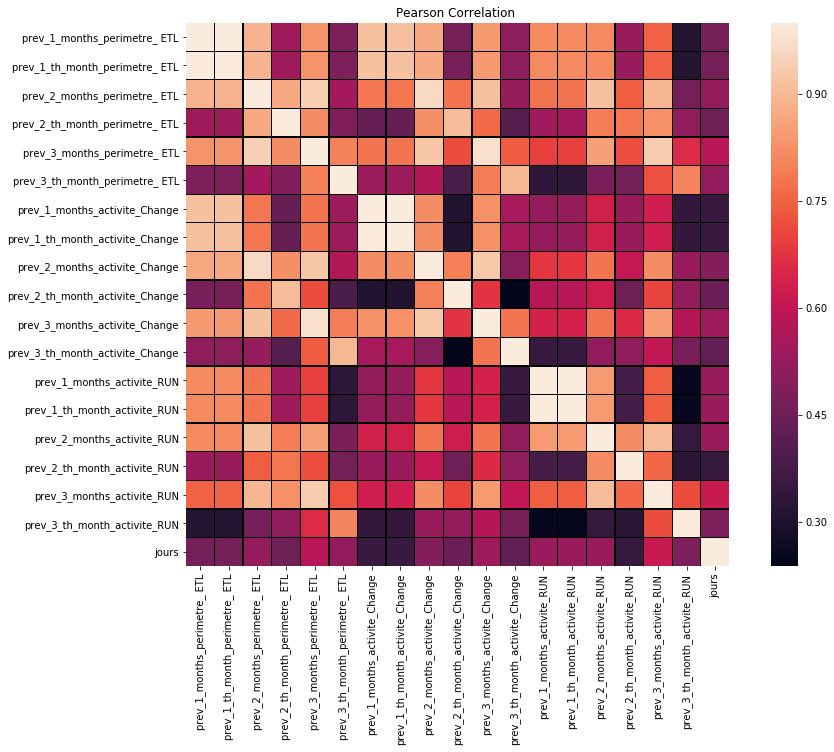

In [16]:
# Set up the matplotlib figure
g, ax2 = plt.subplots(figsize=(15, 10))
plt.title('Pearson Correlation ')
# Draw the heatmap using seaborn
snsCols = columns + ["jours"]
sns.heatmap(train[snsCols].astype(float).corr(),linewidths=0.25,vmax=1.0, square=True, linecolor='black')

Feature ranking:
1. prev_1_th_month_activite_Change (0.095678)
2. prev_2_months_perimetre_ ETL (0.077166)
3. prev_3_th_month_activite_Change (0.075668)
4. prev_3_months_perimetre_ ETL (0.070844)
5. prev_1_months_activite_Change (0.068433)
6. prev_2_months_activite_Change (0.058649)
7. prev_3_th_month_perimetre_ ETL (0.058642)
8. prev_2_th_month_activite_Change (0.057937)
9. prev_2_months_activite_RUN (0.046304)
10. prev_1_th_month_activite_RUN (0.044553)
11. prev_3_months_activite_Change (0.042959)
12. prev_2_th_month_perimetre_ ETL (0.037969)
13. prev_1_th_month_perimetre_ ETL (0.037726)
14. prev_1_months_activite_RUN (0.033808)
15. prev_1_months_perimetre_ ETL (0.032882)


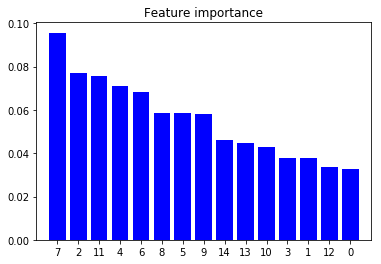

In [30]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from numpy import *
from sklearn.feature_selection import mutual_info_classif 
from sklearn.feature_selection import mutual_info_regression


#RF : RandomForestClassifier
forest = RF(n_estimators=140)
# y4 : more days 
forest_fit = forest.fit(X_scaled, y4)

importances = forest_fit.feature_importances_[:15]

# numpy.std : Returns the standard deviation, a measure of the spread of a distribution
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
# Renvoie un tableau des indices dans l'ordre où ils seraient après un tri
indices = np.argsort(importances)[::-1]


#Print the feature ranking
print("Feature ranking:")
features = [x for y, x in sorted(zip(importances,columns), reverse=True)]
for f in range(15):
    print("%d. %s (%f)" % (f+1, features[f], importances[indices[f]]))

    #plot the feature importances of the forest
plt.figure()
plt.title("Feature importance")
plt.bar(range(15), importances[indices][:15], color="b", align="center")
plt.xticks(range(15), indices)
plt.xlim([-1,15])
plt.show()

In [283]:
 # Feature importance is very volatile. Not enough data.

In [31]:
def run_cv(X,y,clf_class,**kwargs):
    kf = KFold(n_splits=3)
    y_pred = y.copy()
  
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
    return y_pred

In [32]:
from sklearn.metrics import recall_score
import time
# Test different models
models = ["Logistic Regression", "Gradient Boosting Classifier", "Support vector machines",
          "Random forest","K-nearest-neighbors"]
algos = [LR, GBC, SVC, RF, KNN]

In [36]:
# moreAsking

targets = [y3,y4,y5,y6]

description = ["moreAsking ( more requests than during previous month) : ",
               "moreDays : ( more days than during previous month) ",
               "moreDays_10% : (positive variation of + de 10 % / previous month) ",
               "lessDays_10% : (negative variation of + de 10 % / previous month)"]
for j, target in enumerate(targets) :
    scores = [] 
    for i, row in enumerate(models):
        from sklearn.metrics import f1_score
        y_pred = run_cv(X_scaled,target,algos[i])
        f1_score = f1_score(target, y_pred, average=None)
        scores.append(f1_score)
    f1 = [elt[0]+elt[1] for elt in scores]
    indice = f1.index(max(f1))
    
    print (description[j])
    print ("  -  Best model : Accuracy: {0:0.2f}, Recall: {1:0.2f} ({2:s})\n".format(scores[indice][0], scores[indice][1], models[indice]))

moreAsking ( more requests than during previous month) : 
  -  Best model : Accuracy: 0.72, Recall: 0.63 (Gradient Boosting Classifier)

moreDays : ( more days than during previous month) 
  -  Best model : Accuracy: 0.44, Recall: 0.62 (Gradient Boosting Classifier)

moreDays_10% : (positive variation of + de 10 % / previous month) 
  -  Best model : Accuracy: 0.64, Recall: 0.64 (Logistic Regression)

lessDays_10% : (negative variation of + de 10 % / previous month)
  -  Best model : Accuracy: 0.67, Recall: 0.47 (Logistic Regression)

